In [12]:
from zipfile import ZipFile
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import seaborn as sns
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import tensorflow as tf
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Normalize, Compose, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation

**Extract the folders from the zip file**

In [ ]:
path = []
with ZipFile('/content/Dataset Trash.zip', 'r') as zip:
    for file in zip.namelist():
        if file.startswith('TrashType_Image_Dataset/glass/'):
          zip.extract(file, '/content/dataset/glass/')
        elif file.startswith('TrashType_Image_Dataset/cardboard/'):
          zip.extract(file, '/content/dataset/cardboard/')
        elif file.startswith('TrashType_Image_Dataset/metal/'):
          zip.extract(file, '/content/dataset/metal/')
        elif file.startswith('TrashType_Image_Dataset/paper/'):
          zip.extract(file, '/content/dataset/paper/')
        elif file.startswith('TrashType_Image_Dataset/plastic/'):
          zip.extract(file, '/content/dataset/plastic/')
        elif file.startswith('TrashType_Image_Dataset/trash/'):
          zip.extract(file, '/content/dataset/trash/')

**Normalizing the images**

In [16]:
def normalize_images(image_dir, batch_size=128):
    # VGG16 mean values for normalization
    mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)

    # Create a dataset from image files
    image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)
                   if filename.endswith(".jpg") or filename.endswith(".png")]
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    def preprocess_image(img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = tf.cast(img, tf.float32)

        # Light normalization: Adjust brightness and contrast
        img = tf.image.adjust_brightness(img, delta=0.1)
        img = tf.image.adjust_contrast(img, contrast_factor=1.2)

        img -= mean
        return img

    # Apply preprocessing to each image
    image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    image_dataset = image_dataset.batch(batch_size)

    # Convert the dataset to a numpy array
    image_data = np.concatenate(list(image_dataset.as_numpy_iterator()))

    return image_data

# List of paths for each waist type
waist_paths = [
    '/content/dataset/glass/TrashType_Image_Dataset/glass',
    '/content/dataset/cardboard/TrashType_Image_Dataset/cardboard',
    '/content/dataset/metal/TrashType_Image_Dataset/metal',
    '/content/dataset/paper/TrashType_Image_Dataset/paper',
    '/content/dataset/plastic/TrashType_Image_Dataset/plastic',
    '/content/dataset/trash/TrashType_Image_Dataset/trash'
]

# Initialize an empty dictionary to store normalized image data
normalized_data_dict = {}


In [17]:
# Loop through each waist type
for waist_path in waist_paths:
    if os.path.exists(waist_path):
        waist_type = os.path.basename(waist_path)
        normalized_images = normalize_images(waist_path)
        normalized_data_dict[waist_type] = normalized_images
    else:
        print(f"Folder not found: {waist_path}")

# Extract the normalized image data and labels from the dictionary
waist_types = list(normalized_data_dict.keys())
all_images = np.concatenate(list(normalized_data_dict.values()))
all_labels = np.concatenate([np.full(len(v), i) for i, v in enumerate(normalized_data_dict.values())])

# Calculate the total number of images
total_images = all_images.shape[0]

# Reshape the images to include the channel dimension (VGG16 expects 3 channels)
all_images_reshaped = all_images.reshape(total_images, 224, 224, 3)

# Create an ImageDataGenerator with data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation up to 20 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill missing pixels with the nearest value
)

# Fit the generator on your training data
datagen.fit(all_images_reshaped)

# Shuffle the data
indices = np.arange(len(all_images))
np.random.shuffle(indices)
shuffled_images = all_images_reshaped[indices]
shuffled_labels = all_labels[indices]

# Split the shuffled data
train_images, test_images, train_labels, test_labels = train_test_split(
    shuffled_images, shuffled_labels, test_size=0.2, random_state=42
)

**Model Training**

In [ ]:
# Set the number of classes (waist types)
num_classes = 6

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all the layers in the feature extractor
for param in vgg16.features.parameters():
    param.requires_grad = False

# Replacing the classifier with a new one that fits the number of classes
vgg16.classifier[6] = nn.Linear(4096, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

# Convert the numpy arrays to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Permuting the dimensions to match the expected format (batch_size, channels, height, width)
train_images_tensor = train_images_tensor.permute(0, 3, 1, 2)
test_images_tensor = test_images_tensor.permute(0, 3, 1, 2)

# creating the DataLoader with the correctly shaped tensors
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Rest of your training code
num_epochs = 15
for epoch in range(num_epochs):
    vgg16.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Accuracy: {epoch_accuracy:.2f}%")


**Evaluating**

In [19]:
# Evaluate the model on the test data to get the final accuracy
vgg16.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f'Final Test Accuracy: {final_accuracy:.2f}%')

Final Test Accuracy: 77.27%


In [20]:
# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test data
vgg16.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the scores
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.7854
Recall: 0.7727
F1 Score: 0.7675


**visualization**

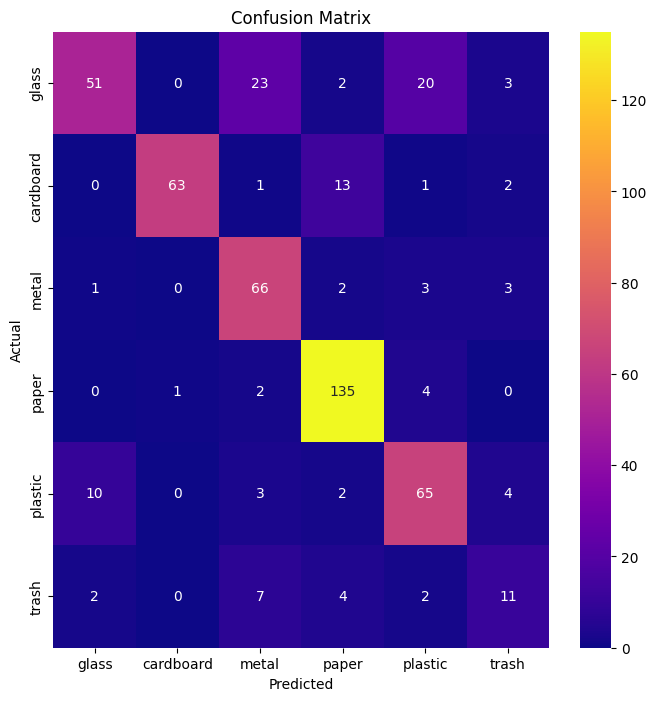

In [21]:
class_names = ['glass', 'cardboard', 'metal', 'paper', 'plastic', 'trash']

# Assuming you have a function to get predictions and true labels from your test_loader
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)
    return all_preds, all_labels

# Get predictions and true labels
with torch.no_grad():
    vgg16.eval()
    predictions, true_labels = get_all_preds(vgg16, test_loader)

# Convert to class predictions
_, predicted_classes = torch.max(predictions, 1)
true_classes = true_labels

# Compute the confusion matrix
cm = confusion_matrix(true_classes.numpy(), predicted_classes.numpy())

# Plot the confusion matrix with class names
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

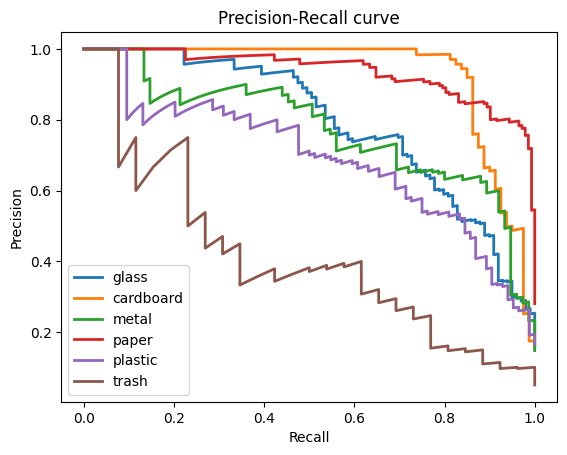

In [22]:
# Binarize the labels for multi-class precision-recall curve
true_labels_bin = label_binarize(true_classes.numpy(), classes=[0, 1, 2, 3, 4, 5])
predictions_bin = label_binarize(predicted_classes.numpy(), classes=[0, 1, 2, 3, 4, 5])

# Calculate precision and recall for each class
precision = dict()
recall = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels_bin[:, i], predictions[:, i])

# Plot the precision-recall curve with class names
for i in range(num_classes):
    plt.plot(recall[i], precision[i], lw=2, label=class_names[i])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title('Precision-Recall curve')
plt.show()

**Real Test**

In [25]:
# Class names
class_names = ['glass', 'cardboard', 'metal', 'paper', 'plastic', 'trash']

# Function to preprocess the image
def preprocess_image(image_path):
    # VGG16 mean values for normalization
    mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)

    # Read the image in RGB format
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (224, 224))  # Resize the image
    img = img.astype(np.float32)  # Convert to float32
    img -= mean  # Subtract mean values
    img = np.transpose(img, (2, 0, 1))  # Change data layout to CxHxW
    return img

# Function to predict the class of an image
def predict_image_class(image_path, model, class_names):
    # Preprocess the image
    img = preprocess_image(image_path)

    # Convert to a batch of 1
    img_tensor = torch.tensor(img).unsqueeze(0)

    # Forward pass through the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(img_tensor)

    # Get the predicted class index
    _, predicted_idx = torch.max(outputs, 1)
    predicted_idx = predicted_idx.item()  # Convert to an integer

    # Map the index to the class name
    predicted_class = class_names[predicted_idx]
    return predicted_class

# Example usage
image_path = input("Please enter the path of your image: ")
predicted_class = predict_image_class(image_path, vgg16, class_names)
print(f"The image is predicted to be: {predicted_class} with a {final_accuracy:.2f}% chance")

Please enter the path of your image: /content/IMG_20240412_125850.jpg
The image is predicted to be: plastic with a 77.27% chance
